In [58]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.stats as stat
#from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

[2. 2.]
(7, 1000, 2)
[-1  1 -1 ...  1  1 -1]
(7, 5000)
498
[[1 1 0 ... 1 1 1]
 [1 0 0 ... 0 1 0]
 [0 0 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
[[0 1 1 ... 0 1 1]
 [1 0 0 ... 0 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [1 1 1 ... 0 0 1]
 [0 1 0 ... 1 0 0]]


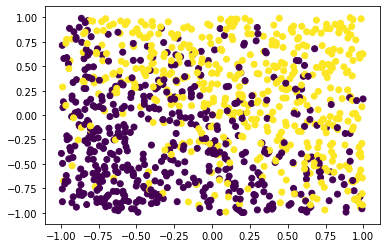

In [101]:
distorts = [
            lambda eta: eta, 
#             lambda eta:0.3+0.4*eta,
            lambda eta:stat.beta.cdf(eta,0.2,0.2),
            lambda eta:stat.beta.cdf(eta,5.,5.),
            lambda eta:stat.beta.cdf(eta,0.5,2),
            lambda eta:stat.beta.cdf(eta,2,0.5),
            lambda eta:stat.beta.cdf(eta,20,80)*0.25 +
                       stat.beta.cdf(eta,80,20)*0.25 + 
                       stat.beta.cdf(eta,0.1,0.1)*0.5,
            lambda eta:stat.beta.cdf(eta,30,10)*0.5 +
                       stat.beta.cdf(eta,0.1,0.1)*0.5
           ]

num_annots = len(distorts)

num_dp_per_annot = 1000
num_test = 5000
data_dim = 2
w_star = 2.*np.ones((data_dim))
print(w_star)
np.random.seed(100)
x_all_train = 2*np.random.rand(num_annots, num_dp_per_annot, data_dim)-1
eta_all_train = 1./(1+np.exp(-np.dot(x_all_train,w_star)))
y_all_train = 2*(np.random.rand(*eta_all_train.shape)<eta_all_train) - 1
print(x_all_train.shape)
x_all_test = 2*np.random.rand(num_test, data_dim)-1
eta_all_test = 1./(1+np.exp(-np.dot(x_all_test,w_star)))
y_all_test = 2*(np.random.rand(*eta_all_test.shape)<eta_all_test) - 1

print(y_all_test)
eta_tilde_all_train = np.array([distorts[i](eta_all_train[i]) for i in range(num_annots)])
y_tilde_all_train = 2*(np.random.rand(*eta_tilde_all_train.shape)<eta_tilde_all_train) - 1

eta_tilde_all_test = np.array([distorts[i](eta_all_test) for i in range(num_annots)])
y_tilde_all_test = 2*(np.random.rand(*eta_tilde_all_test.shape)<eta_tilde_all_test) - 1
print(y_tilde_all_test.shape)

j=0
plt.scatter(x_all_train[j][:,0], x_all_train[j][:,1], c= y_all_train[j])

print(np.sum(y_all_train[j]==+1))
X_train_d = x_all_train
Y_train_d = y_tilde_all_train
Y_train_d = (Y_train_d + 1)//2
X_test_d = []
for i in range(num_annots):
    X_test_d.append(x_all_test)
X_test_d = np.array(X_test_d)
Y_test_d = y_tilde_all_test
Y_test_d = (Y_test_d + 1)//2
print(Y_train_d)
print(Y_test_d)
#print(X_train_d[1])

In [102]:
def accuracy_score(Y, Y_pred):
    loss = 0.0
    #print(Y.shape[0])
    for i in range(Y.shape[0]):
        loss = loss + ((Y[i]- Y_pred[i])**2)
    return loss/(Y.shape[0])
        

In [103]:
#Baseline-1
clf_list = []
accuracy_list = []
for i in range(X_train_d.shape[0]):
    #Y_train_d[i] =Y_train_d[i].astype('int')
    #Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(X_train_d[i], Y_train_d[i])
    Y_pred = clf.predict_proba(X_test_d[i])[:,1]
    #print(Y_pred)
    accuracy_list.append(accuracy_score(Y_test_d[i],Y_pred))
accuracy_list
#Y_test_distort[0].shape

[0.16955275935649605,
 0.2358707376251144,
 0.08102791883664831,
 0.11040804370309396,
 0.1192175997951254,
 0.22028164444585127,
 0.19635320893604966]

In [104]:
Z_train = list(range(num_annots))
Z_train_label = list(range(num_annots))
for i in range(num_annots):
    temp = []
    temp_label = []
    for j in range(len(X_train_d[i])):
        for k in range(j+1,len(X_train_d[i])):
            if(Y_train_d[i][j] != Y_train_d[i][k]):
                temp.append(X_train_d[i][j]-X_train_d[i][k] )
                temp_label.append((Y_train_d[i][j]- Y_train_d[i][k]+1)//2)
    Z_train[i] = np.array(temp)
    Z_train_label[i] = np.array(temp_label)

print(Z_train_label)


[array([1, 1, 1, ..., 0, 0, 0], dtype=int32), array([1, 1, 1, ..., 0, 0, 1], dtype=int32), array([0, 0, 0, ..., 0, 0, 0], dtype=int32), array([1, 1, 1, ..., 0, 0, 0], dtype=int32), array([0, 0, 0, ..., 1, 1, 1], dtype=int32), array([1, 1, 1, ..., 1, 1, 1], dtype=int32), array([0, 0, 0, ..., 1, 0, 1], dtype=int32)]


In [105]:
sr_clf_list = []
sr_accuracy_list = []
for i in range(num_annots):
    #Z_train_label[i] =Z_train_label[i].astype('int')
    #Y_test_d[i] =Y_test_d[i].astype('int')
    clf = LogisticRegression(solver='lbfgs').fit(Z_train[i], Z_train_label[i])
    sr_clf_list.append(clf)

In [106]:
sr_probab = list(range(num_annots))
iso_reg = list(range(num_annots))
for i in range(num_annots):
    sr_probab[i] = (sr_clf_list[i].predict_proba(X_train_d[i]))[:,1]
    iso_reg[i] = IsotonicRegression(out_of_bounds = 'clip').fit(sr_probab[i],Y_train_d[i])
    

In [107]:
Y_pred_sr = list(range(num_annots))
sr_accuracy_list = list(range(num_annots))
for i in range(num_annots):
    temp=  iso_reg[i].predict((sr_clf_list[i].predict_proba(X_test_d[i]))[:,1])
    #print(max(temp))
    sr_accuracy_list[i] = accuracy_score(Y_test_d[i],np.array(temp))
sr_accuracy_list

[0.17120025006723966,
 0.237306616850603,
 0.08092061439661201,
 0.1114853286678933,
 0.11895710483206462,
 0.2196619309286145,
 0.18783853354582777]

In [108]:
#Joint Ranking (Training Phase)
Z_train = []
Z_train_label = []
temp  = []
temp_label = []
for i in range(num_annots):
    for j in range(len(X_train_d[i])):
        for k in range(j+1,len(X_train_d[i])):
            if(Y_train_d[i][j] != Y_train_d[i][k]):
                temp.append(X_train_d[i][j]-X_train_d[i][k] )
                temp_label.append((Y_train_d[i][j]- Y_train_d[i][k] + 1)//2)
Z_train = np.array(temp)
Z_train_label = np.array(temp_label)
                

In [109]:
#Logistic Regression separately for each labeller on the transformed data
jr_clf = 0
jr_accuracy = 0
#Z_train_label =Z_train_label.astype('int')
jr_clf = LogisticRegression(solver='lbfgs').fit(Z_train, Z_train_label)

In [110]:
jr_probab =list(range(num_annots))
iso_reg = list(range(num_annots))
for i in range(num_annots):
    jr_probab[i] = (jr_clf.predict_proba(X_train_d[i]))[:,1]  # sigma(w^T(x))
    iso_reg[i] = IsotonicRegression(out_of_bounds = 'clip').fit(jr_probab[i],Y_train_d[i]) #u_i(sigma(w^T(x)))
    

In [111]:
#Joint Raking Testing Phase
Y_pred_jr = list(range(num_annots))
jr_accuracy_list = list(range(num_annots))
for i in range(num_annots):
    temp=  iso_reg[i].predict((jr_clf.predict_proba(X_test_d[i]))[:,1]) #u_i(sigma(w^T(x)))
    
    jr_accuracy_list[i] = accuracy_score(Y_test_d[i],np.array(temp)) #loss calculation
jr_accuracy_list

[0.17059947352841523,
 0.23782629486184728,
 0.08109912979380145,
 0.11155583459816103,
 0.119115908866433,
 0.21825165205084227,
 0.1874567438387092]

In [112]:
#Separate Slisotron(Training Phase)
T = 100  # no. of iterations
u = list(range(num_annots))   # distortion applied by each annotator
w = []          #weight vector for each annotator
for i in range(num_annots):
    w.append(np.array([1,0]))   # Initialisation of w
for i in range(num_annots):
    for t in range(T):
        temp = []
        for x in X_train_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))  #(sigma(w_i^T(x)))
        temp = np.array(temp)
        u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i]) #updating u(Isotonic Regression)
        iso_predict = u[i].predict(temp) #(u_i(sigma(w_i^T(x)))
        sum1 = 0
        for j in range(len(X_train_d[i])):
            sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
        sum1 = sum1/len(X_train_d[i])
        w[i] = w[i] + sum1  #updating w
    print(w[i])
    

[0.43189101 0.41688389]
[0.19126028 0.18168967]
[0.6446645 0.6469887]
[0.50840847 0.5307264 ]
[0.53139109 0.49825473]
[0.26774514 0.31538085]
[0.1541784  0.16446308]


In [113]:
#Separate Slisotron(Testing Phase)
sl_accuracy_list = list(range(num_annots))
Y_pred_sl = list(range(num_annots))
for i in range(num_annots):
    pred_class = []
    temp = []
    for x in X_test_d[i]:
        temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w[i]),x)))))     #(sigma(w_i^T(x)))
    temp = np.array(temp)
    pred_prob = u[i].predict(temp)           #(u_i(sigma(w_i^T(x)))
    sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob))) #loss calculation
    
sl_accuracy_list
            
        

[0.17112558633396496,
 0.23736473572703362,
 0.08085066386711481,
 0.11149987611802346,
 0.11903074048411208,
 0.21940317979507853,
 0.18835068965888155]

In [114]:
#Joint Slisotron (Training Phase)
T = 100
u = list(range(num_annots))
w = 0           #same 'w' for all labellers
for i in range(num_annots):
    w = np.array([1,0])
for t in range(T):
    sum1 = 0
    for i in range(num_annots):
        temp = []
        for x in X_train_d[i]:
            temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w),x)))))   #calculating sigma(w_T(x))
        temp = np.array(temp)
        u[i] = IsotonicRegression(out_of_bounds = 'clip').fit(temp,Y_train_d[i])  # updating u_i using isotonic regression
        
        iso_predict = u[i].predict(temp)     # u_i(sigma(w_T(x)))
        for j in range(len(X_train_d[i])):
            sum1 = sum1 + (Y_train_d[i][j] - iso_predict[j])*(X_train_d[i][j])
    sum1 = sum1/(len(X_train_d[0])*num_annots)
    w = w + sum1  #updating 'w' considering all four labellers
print(w)
    

[0.39680492 0.40116448]


In [115]:
sl_accuracy_list = list(range(num_annots))
Y_pred_sl = list(range(num_annots))
for i in range(num_annots):
    pred_class = []
    temp = []
    for x in X_test_d[i]:
        temp.append(1/(1+np.exp(-(np.matmul(np.transpose(w),x)))))
    temp = np.array(temp)
    pred_prob = u[i].predict(temp)
    for j in range(len(X_test_d[i])):
        if(pred_prob[i] >=0.5):
            pred_class.append(1)
        else:
            pred_class.append(0)
    pred_class = np.array(pred_class)
    Y_pred_sl[i] = pred_class
    sl_accuracy_list[i] = (accuracy_score(Y_test_d[i],np.array(pred_prob)))
    
sl_accuracy_list

[0.1707817260050076,
 0.23797212066681478,
 0.08096923904820748,
 0.11157398286693032,
 0.11916887636602778,
 0.21807976474272364,
 0.1875928003301475]